### Now we'll talk about convolutions neural networks and in this notebook, we'll know how by using the dataset we can do:
* Data augmentation
* Early stopping
* Decaying learning rate

We use the [batch class](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/II.CNN/my_batch.py) and [model](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/II.CNN/simple_conv_model.py).

In [1]:
import sys

import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook as tqn
from matplotlib import pyplot as plt
%matplotlib inline
sys.path.append('../..')

import utils
from my_batch import MnistBatch
from simple_conv_model import ConvModel

from dataset import Dataset, DatasetIndex, B,V,F
from dataset.dataset.opensets import MNIST

Instead of generating data, we use a basic batch class with preloaded [MNIST](https://analysiscenter.github.io/dataset/api/dataset.opensets.html#mnist) dataset.

In [2]:
mnist = MNIST(batch_class=MnistBatch)

ExtractingExtractingExtracting   Extracting/tmp/train-labels-idx1-ubyte.gz/tmp/train-images-idx3-ubyte.gz/tmp/t10k-images-idx3-ubyte.gz 


/tmp/t10k-labels-idx1-ubyte.gz


As we already learned from the [first task](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/I.Dataset/I.Dataset.ipynb), the first place we need to create the config and pipeline, for train and test our model.

Let's create a config for a model. If you open the file with the [model](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/II.CNN/simple_conv_model.py) you can see [__default_config__](https://analysiscenter.github.io/dataset/api/dataset.models.tf.base.html#dataset.models.tf.base.TFModel.default_config). It is a function, that allows you adding the default configuration to model.

But if you want to override default config you can add parameters in model config. For example:

ConvModel has dict __config__ with key __'body'__. You can override it by add in __model_config__ key __'body'__ with dict of params to body (as in [model](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/II.CNN/simple_conv_model.py) file). 

Or add useful params by typing in a __model_config__ key like __'body/layout'__ and params to this key. Similar way use in key __'input_block/inputs'__ or __'head/units'__.

In [3]:
inputs_config = dict(images={'shape': (28, 28, 1)},
                     labels={'classes': (10), 
                             'transform': 'ohe', 
                             'name': 'targets'})

model_config = {'inputs': inputs_config,
                'loss': 'softmax_cross_entropy',
                'decay': ('exp', {'learning_rate': 0.001,
                                  'decay_steps': 150,
                                  'decay_rate': 0.96}),
                'optimizer': 'RMSProp',
                'input_block/inputs': 'images',
                'head/units': 10,
                'output': dict(ops=['labels', 'proba', 'accuracy'])}

And don't forget about feed dict.

In [4]:
data_dict = {'images': B('images'),
             'labels': B('labels')}

After preparing we can create a pipeline, but it is worth paying attention to the fact that __random_rotate__ and __random_scale__ are elements of the __ImagesBatch__ class(parent our class). You can see all writing augmentations in [examples](https://github.com/analysiscenter/dataset/blob/master/examples/simple_but_ugly/image_basic.py) for the Dataset.

In contrast to them __shift_flattned_pic__ is function from [my_batch](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/II.CNN/my_batch.py). It is interesting because it runs in parrallel. About parallel method read [docs](https://analysiscenter.github.io/dataset/intro/parallel.html).

In [5]:
train_pipeline = (mnist.train.p
                 .shift_flattened_pic()
                 .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True) #random rotate with angle 
#                                                                           from -30 degrees to 30 degrees
                 .random_scale(p=.8, factor=(.7, 1.3)) # Resizing from 100% to random in (80% - 120%)
                 .init_variable('train_accuracy', init_on_each_run=list)
                 .init_model('dynamic',
                             ConvModel,
                             'conv',
                              config=model_config)
                 .train_model('conv',
                              fetches='accuracy',
                              feed_dict=data_dict,
                              save_to=V('train_accuracy'), mode='a'))

And test on same augmented data.

In [6]:
test_pipeline = (mnist.test.p
                 .import_model('conv', train_pipeline)
                 .shift_flattened_pic()
                 .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True) #random rotate with angle 
#                                                                           from -30 degrees to 30 degrees
                 .random_scale(p=.8, factor=(.7, 1.3)) # Resizing from 100% to random in (80% - 120%)
                 .init_variable('test_accuracy', init_on_each_run=list)
                 .predict_model('conv', 
                             fetches='ConvModel/accuracy',
                             feed_dict=data_dict,
                             save_to=V('test_accuracy'), mode='a'))

We introduce early stopping to stop the model when average accuracy in 'window' epochs will be more than 0.95 percent.

In [7]:
MAX_ITER = 700
window = 50
average = [0]
batch_size = 100

for curr_iter in tqn(range(1, MAX_ITER + 1)):

    train_pipeline.next_batch(batch_size, n_epochs=None)
    test_pipeline.next_batch(batch_size, n_epochs=None)

    if curr_iter % window == 0:
        average.append(np.mean(test_pipeline.get_variable('test_accuracy')[curr_iter - window:]))

    #Early stopping   
    if average[-1] > 0.95:
        print('Early stop on {} iter. Acc: {}'.format(curr_iter, stats[-1]))
        break

Widget Javascript not detected.  It may not be installed or enabled properly.


Now we predict image class on test data and draw accuracy graph.

../../utils.py:37: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../../utils.py:38: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


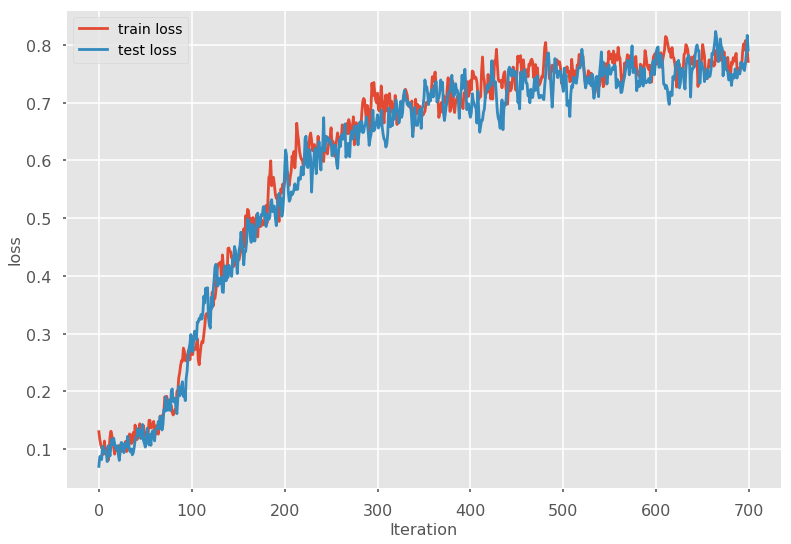

In [8]:
train_accuracy = train_pipeline.get_variable('train_accuracy')
test_accuracy = test_pipeline.get_variable('test_accuracy')
utils.draw(train_accuracy,'train', test_accuracy, 'test', 'loss')

Accuracy graph it probably good, but what about real predictions?

In [9]:
validation_pipeline = (mnist.test.p
                       .import_model('conv', train_pipeline)
                       .shift_flattened_pic()
                       .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True) #random rotate with angle 
        #                                                                           from -30 degrees to 30 degrees
                       .random_scale(p=.8, factor=(.7, 1.3)) # Resizing from 100% to random in (80% - 120%)
                       .init_variable('answers', init_on_each_run=list)
                       .init_variable('img', init_on_each_run=list)
                       .init_variable('predict', init_on_each_run=list)
                       .init_variable('prob', init_on_each_run=list)
                       .predict_model('conv', 
                                      fetches=['labels', 
                                               'images', 
                                               'ConvModel/predicted_labels', 
                                               'ConvModel/predicted_proba'],
                                      feed_dict=data_dict,
                                      save_to=[V('answers'), V('img'), V('predict'), V('prob')], mode='a'))

It's always interesting to look at the images, let's draw it.

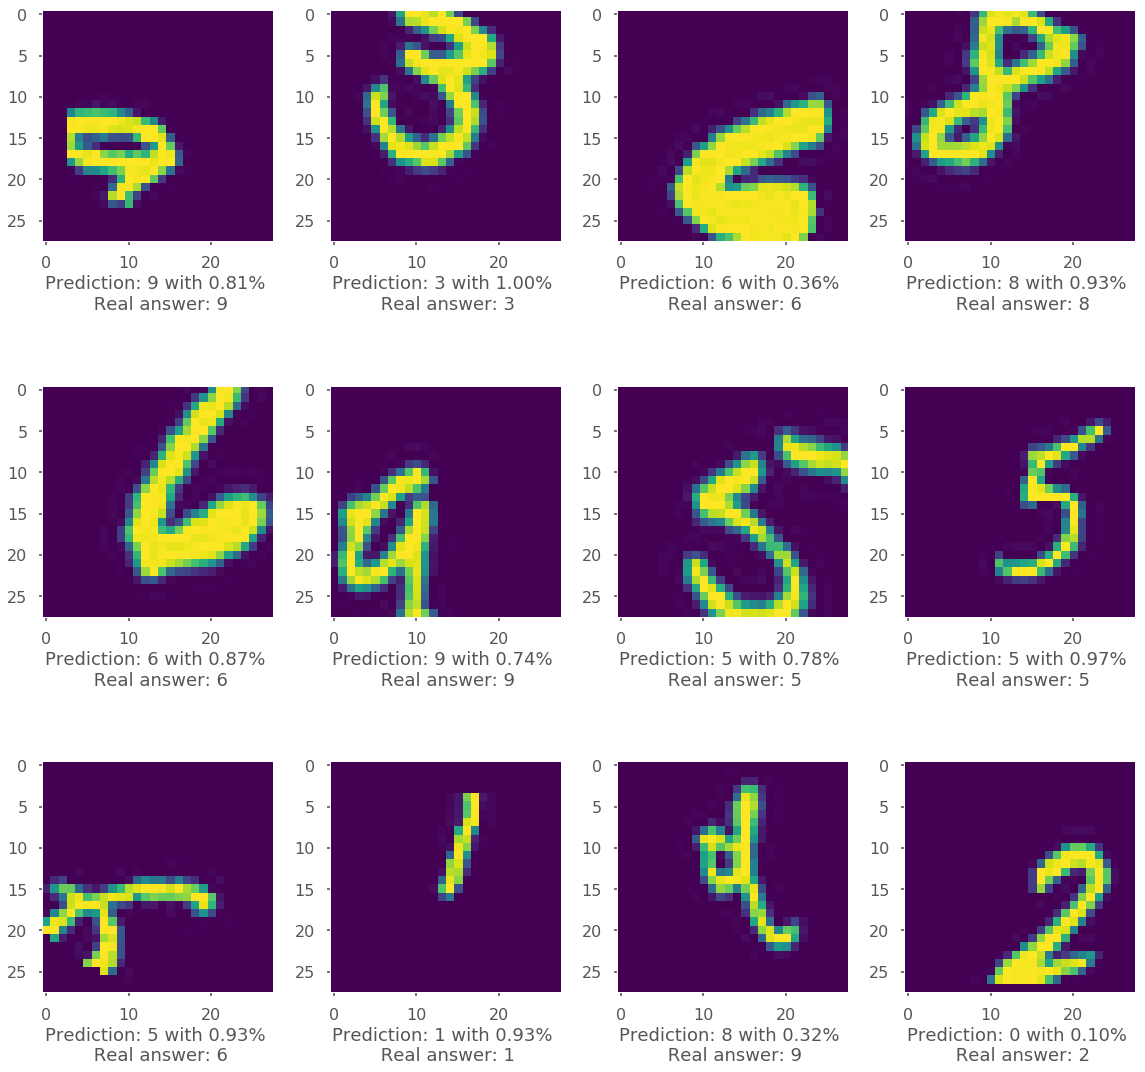

In [10]:
_, ax = plt.subplots(3, 4, figsize=(16, 16))
ax = ax.reshape(-1)


for num_batch in range(12):
    validation_pipeline.next_batch(1, n_epochs=None, shuffle=True)
    answer= validation_pipeline.get_variable('answers')
    img = validation_pipeline.get_variable('img')
    predict = validation_pipeline.get_variable('predict')
    prob = validation_pipeline.get_variable('prob')
    ax[num_batch].imshow(img[-1].reshape(-1, 28))
    ax[num_batch].set_xlabel('Prediction: {} with {:.2f}% \n Real answer: {}'.format(predict[-1][0],
                                                                                     prob[-1][0] \
                                                                                     [np.argmax(prob[-1])], \
                                                                                      answer[-1][0]),\
                                                                                      fontsize=18)
    ax[num_batch].grid()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

### Conclusions
* Today we acquainted with convolutions neural network and how a dataset can to it.
* Now you can use MNIST data without load it in the pipeline.
* Discover the data augmentation.
* Get to know how to configurate(configure) the model using model config.
* Find out that network can teach rotate and scale changes. 

### And what next?
Because you know how to configurate(configure) convolution model, you can create a model with:
* MNIST with 3-channels data, instead 1 in our example.
* Create config to our model, with own parameters of the network. Your goal is 0.93 on the test data!
Good luck!


In next [notebook](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/III.Models/III.Models.py), we'll know what is best ResNet34 or ResNet50. Interested? Click.